In [2]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv("Final_cleaned_data.csv")
df.head()

,ISBN,Publisher,Book_Title,Book_Author,First_Publish_Year,Edition_Count,Book_Age,Edition_Count_Category,Total_Reviews,No_of_Pages,Book_Length_Category,Popularity_Score,Book_Price,Bestseller
0,1881320189,River City Pub,Goodbye to the Buttermilk Sky,Julia Oliver,1994,1,33,Low,189,363,Medium,113.8,32.15,1
1,0440295734,Bantam Books,The Testament,John Grisham,1999,62,26,High,588,474,Medium,377.6,37.70,1
2,0553502271,Random House Audio,The Testament,John Grisham,1999,61,26,High,8,116,Short,29.2,5.80,0
3,0439095026,Scholastic,Tell Me This Isn't Happening,Robynn Clairday,1999,1,26,Low,165,440,Medium,99.4,32.00,1
4,0060168013,Harpercollins,Pigs in Heaven,Barbara Kingsolver,1993,13,32,Medium,88,451,Medium,58.0,38.55,1


In [7]:
features = ['Edition_Count', 'Book_Age', 'Total_Reviews', 'No_of_Pages', 'Popularity_Score', 'Book_Price']
X_full = df[features].copy()
y = df['Bestseller'].values.reshape(-1, 1)
print("Dataset after selecting features:")
print(X_full.head())
X_plot = X_full[['Popularity_Score', 'Book_Price']].copy().values
X_model = X_full.values

Dataset after selecting features:
   Edition_Count  Book_Age  Total_Reviews  No_of_Pages  Popularity_Score  \
0              1        33            189          363             113.8   
1             62        26            588          474             377.6   
2             61        26              8          116              29.2   
3              1        26            165          440              99.4   
4             13        32             88          451              58.0   

   Book_Price  
0       32.15  
1       37.70  
2        5.80  
3       32.00  
4       38.55  


In [9]:
X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(X_model, y, test_size=0.2, stratify=y)

print("\nTraining Set:")
print(pd.DataFrame(X_train_raw, columns=features).head())
print("\nTesting Set:")
print(pd.DataFrame(X_test_raw, columns=features).head())


Training Set:
   Edition_Count  Book_Age  Total_Reviews  No_of_Pages  Popularity_Score  \
0            1.0      31.0          576.0        494.0             346.0   
1           10.0      28.0          448.0        387.0             272.8   
2            1.0      44.0          375.0        385.0             225.4   
3            6.0      29.0          336.0        750.0             204.0   
4            1.0      26.0          406.0        486.0             244.0   

   Book_Price  
0       36.70  
1       35.35  
2       29.25  
3       49.50  
4       38.30  

Testing Set:
   Edition_Count  Book_Age  Total_Reviews  No_of_Pages  Popularity_Score  \
0           38.0      29.0           84.0        780.0              65.6   
1           12.0      25.0          272.0        542.0             168.0   
2            1.0      24.0          590.0        795.0             354.4   
3            3.0      27.0          392.0        218.0             236.4   
4            1.0      22.0          22

In [11]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_raw, y_train_raw)

# 🔧 FIX: Ensure label is a column vector
y_train_resampled = np.array(y_train_resampled).reshape(-1, 1)

# Check balance after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled.ravel()).value_counts())


Class distribution after SMOTE:
1    734
0    734
Name: count, dtype: int64


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test_raw)

# Add intercept
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y, y_pred):
    epsilon = 1e-10
    return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))

def train_logistic_regression(X, y, lr=0.01, iterations=10000):
    m, n = X.shape
    y = y.reshape(-1, 1)  # ✅ Ensure label is (n_samples, 1)
    weights = np.zeros((n, 1))
    for i in range(iterations):
        z = np.dot(X, weights)
        y_pred = sigmoid(z)
        error = y_pred - y
        gradient = np.dot(X.T, error) / m
        weights -= lr * gradient
        if i % 1000 == 0:
            loss = compute_loss(y, y_pred)
            print(f"Iteration {i} - Loss: {loss:.4f}")
    return weights


In [17]:
weights = train_logistic_regression(X_train, y_train_resampled)

# Predict
y_pred_probs = sigmoid(np.dot(X_test, weights))
y_pred_class = (y_pred_probs >= 0.5).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_class)
conf_matrix = confusion_matrix(y_test, y_pred_class)
class_report = classification_report(y_test, y_pred_class)

print(f"\nAccuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Iteration 0 - Loss: 0.6931
Iteration 1000 - Loss: 0.2258
Iteration 2000 - Loss: 0.1792
Iteration 3000 - Loss: 0.1565
Iteration 4000 - Loss: 0.1424
Iteration 5000 - Loss: 0.1326
Iteration 6000 - Loss: 0.1254
Iteration 7000 - Loss: 0.1199
Iteration 8000 - Loss: 0.1155
Iteration 9000 - Loss: 0.1120

Accuracy: 0.9406

Confusion Matrix:
[[ 17   1]
 [ 11 173]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.94      0.74        18
           1       0.99      0.94      0.97       184

    accuracy                           0.94       202
   macro avg       0.80      0.94      0.85       202
weighted avg       0.96      0.94      0.95       202



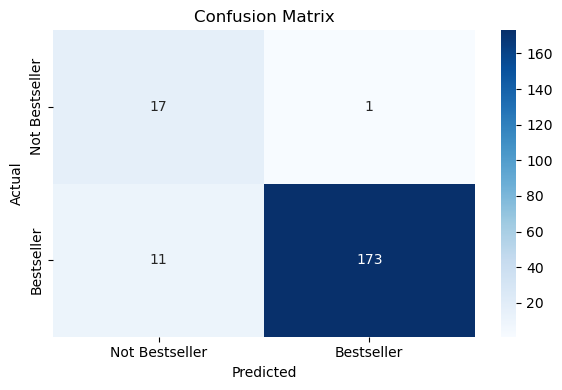

In [19]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Bestseller', 'Bestseller'],
            yticklabels=['Not Bestseller', 'Bestseller'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Iteration 0 - Loss: 0.6931
Iteration 1000 - Loss: 0.2579
Iteration 2000 - Loss: 0.2101
Iteration 3000 - Loss: 0.1883
Iteration 4000 - Loss: 0.1746
Iteration 5000 - Loss: 0.1648
Iteration 6000 - Loss: 0.1573
Iteration 7000 - Loss: 0.1513
Iteration 8000 - Loss: 0.1463
Iteration 9000 - Loss: 0.1421


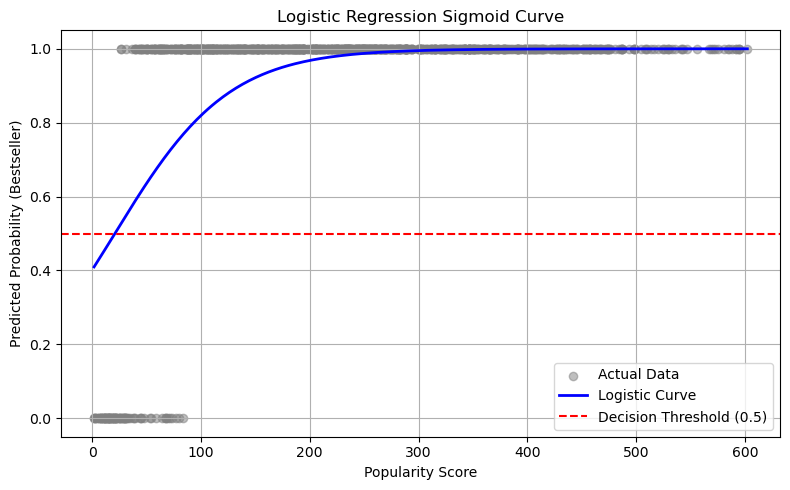

In [23]:
X_single = df[['Popularity_Score']].values
y_single = df['Bestseller'].values.reshape(-1, 1)

scaler_single = StandardScaler()
X_single_scaled = scaler_single.fit_transform(X_single)
X_single_scaled = np.hstack((np.ones((X_single_scaled.shape[0], 1)), X_single_scaled))

weights_single = train_logistic_regression(X_single_scaled, y_single)

X_plot = np.linspace(X_single.min(), X_single.max(), 300).reshape(-1, 1)
X_plot_scaled = scaler_single.transform(X_plot)
X_plot_scaled = np.hstack((np.ones((X_plot_scaled.shape[0], 1)), X_plot_scaled))
y_plot_probs = sigmoid(np.dot(X_plot_scaled, weights_single))

plt.figure(figsize=(8, 5))
plt.scatter(X_single, y_single, color='gray', alpha=0.5, label='Actual Data')
plt.plot(X_plot, y_plot_probs, color='blue', linewidth=2, label='Logistic Curve')
plt.axhline(0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
plt.xlabel("Popularity Score")
plt.ylabel("Predicted Probability (Bestseller)")
plt.title("Logistic Regression Sigmoid Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

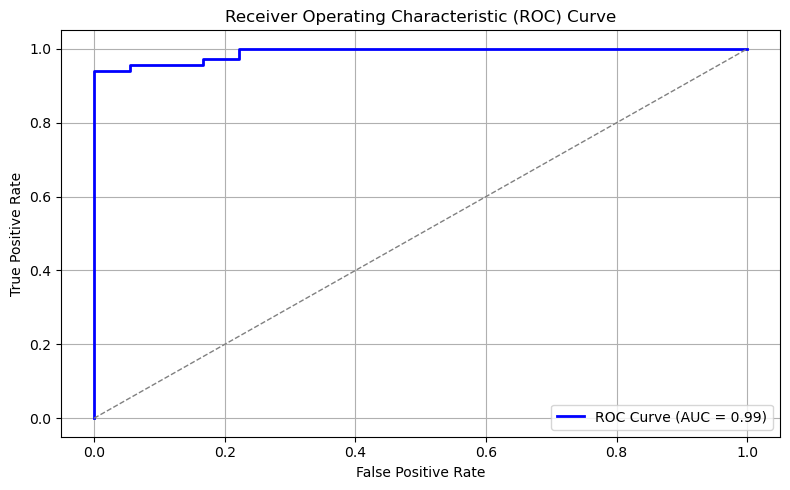

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
